In [304]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.multitest import fdrcorrection
from sklearn.cluster import KMeans

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

gene_names = sc.queries.biomart_annotations('hsapiens', attrs=['ensembl_gene_id', 'hgnc_symbol'], use_cache=True)
adata = sc.datasets.ebi_expression_atlas('E-MTAB-9221')
adata.var = adata.var.join(gene_names[gene_names.ensembl_gene_id.isin(adata.var_names)
                                     ].drop_duplicates('ensembl_gene_id').set_index('ensembl_gene_id'))
adata.var.hgnc_symbol.fillna(pd.Series(adata.var.index.values, index=adata.var.index), inplace=True)
adata.var['ensembl_gene_id'] = adata.var_names
adata.var.set_index('hgnc_symbol', inplace=True)
adata.var_names = adata.var.index
adata.var_names_make_unique()

cell_marker = pd.read_csv('~/Downloads/CellMarker.csv')
cell_marker2 = pd.read_csv('~/Downloads/CellMarker.Experiment.csv')
cell_marker = pd.concat([cell_marker, cell_marker2])
cell_marker = cell_marker[cell_marker.Cancer == 'Normal']

adata.obs['COVID'] = 1 - pd.get_dummies(adata.obs['Factor Value[clinical history]'])['control']

for c in adata.obs.columns:
    if 2 < adata.obs[c].nunique() < 100:
        print(c, adata.obs[c].unique())

Sample Characteristic[sex] ['female', 'male', 'not available']
Categories (3, object): ['female', 'male', 'not available']
Sample Characteristic Ontology Term[sex] ['http://purl.obolibrary.org/obo/PATO_0000383', 'http://purl.obolibrary.org/obo/PATO_0000384', 'nan']
Categories (3, object): ['http://purl.obolibrary.org/obo/PATO_0000383', 'http://purl.obolibrary.org/obo/PATO_0000384', 'nan']
Sample Characteristic[age] ['54 year', '27 year', '58 year', '21 year', '69 year', '26 year', 'not available']
Categories (7, object): ['54 year', '27 year', '58 year', '21 year', '69 year', '26 year', 'not available']
Sample Characteristic[individual] ['Control #1', 'Control #2', 'Control #3', 'SARS-CoV2 pos Mild', 'SARS-CoV2 pos Severe #1', 'SARS-CoV2 pos Severe #2', 'SARS-CoV2 pos Severe #3']
Categories (7, object): ['Control #1', 'Control #2', 'Control #3', 'SARS-CoV2 pos Mild', 'SARS-CoV2 pos Severe #1', 'SARS-CoV2 pos Severe #2', 'SARS-CoV2 pos Severe #3']
Sample Characteristic[clinical history]

In [305]:
def find_grouped_counts(adata, f=10):
    data = adata.copy()
    sc.pp.normalize_total(data, target_sum=1e3)
    sc.pp.log1p(data)
    sc.tl.pca(data, svd_solver='arpack')
    sc.pp.neighbors(data, n_neighbors=250, n_pcs=50)
    sc.tl.leiden(data, resolution=1)
    sc.pp.calculate_qc_metrics(data, inplace=True)
    to_drop = data.obs.total_counts > data.obs.groupby('leiden').total_counts.transform(lambda x: np.percentile(x, f))
    return to_drop

def compute_scores(adata, cell_marker=cell_marker):
    score_cols = []
    marker_grp = cell_marker[~cell_marker['Cell Type'].str.lower()\
                                                        .str.contains('cancer')
                            ].groupby('Cell Type')
    for cell, g in marker_grp:
        gene_list = [] 
        for glist in g['Cell Marker'].tolist():
            gene_list += [g.strip() for g in glist.split(',')]

        gene_list = list(set(gene_list))
        length = (len(gene_list) - np.sum([gene not in adata.raw.var_names for gene in gene_list]) < 3)
        if (length &
            (cell != 'Platelet')):
            continue

        score_cols += [cell]
        sc.tl.score_genes(adata, gene_list, score_name=cell + '_score', use_raw=True)
        
def kmeans_assign(adata):
    score_cols = [c for c in adata.obs.columns if '_score' in c]
    
    km = KMeans(len(score_cols))
    adata.obs['log_total_counts'] = adata.obs.total_counts.apply(np.log10)
    labels = km.fit_predict(adata.obs[score_cols + ['log_total_counts']])
    adata.obs['KMLabel'] = labels
    adata.obs.KMLabel = adata.obs.KMLabel.astype('category')
    label_names = adata.obs.groupby('KMLabel')[score_cols].agg(np.median).idxmax(axis=1).to_dict()
    
    adata.obs['PredictedLabel'] = adata.obs.KMLabel.map(label_names)

In [306]:
def annotate(data):
    adata = data.copy()
    sc.pp.filter_cells(adata, min_genes=50)
    sc.pp.filter_genes(adata, min_cells=10)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adata = adata[adata.obs.n_genes_by_counts.between(0, 7000), :]
    adata = adata[adata.obs.pct_counts_mt.between(2, 20), :]

    # split data into high and low count cells
    h_adata = adata[adata.obs.total_counts > 10 ** 3.5]
    l_adata = adata[adata.obs.total_counts.between(500, 10 ** 3.5)]

    h_adata = h_adata[find_grouped_counts(h_adata, f=5)]
    l_adata = l_adata[find_grouped_counts(l_adata, f=10)]

    sc.pp.normalize_total(h_adata, target_sum=1e3)
    sc.pp.log1p(h_adata)
    sc.pp.highly_variable_genes(h_adata, min_mean=0.005, max_mean=1.5, min_disp=0.5)
    sc.pl.highly_variable_genes(h_adata)
    h_adata.raw = h_adata
    h_adata = h_adata[:, h_adata.var.highly_variable]

    compute_scores(h_adata, cell_marker[cell_marker['Cell Type'] != 'Platelet'])
    kmeans_assign(h_adata)

    sc.pp.normalize_total(l_adata, target_sum=1e3)
    sc.pp.log1p(l_adata)
    sc.pp.highly_variable_genes(l_adata, min_mean=0.005, max_mean=1.5, min_disp=0.5)
    sc.pl.highly_variable_genes(l_adata)
    l_adata.raw = l_adata
    l_adata = l_adata[:, l_adata.var.highly_variable]

    compute_scores(l_adata)
    kmeans_assign(l_adata)

    adata = h_adata.concatenate(l_adata, index_unique=None)
    return adata.obs.PredictedLabel

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


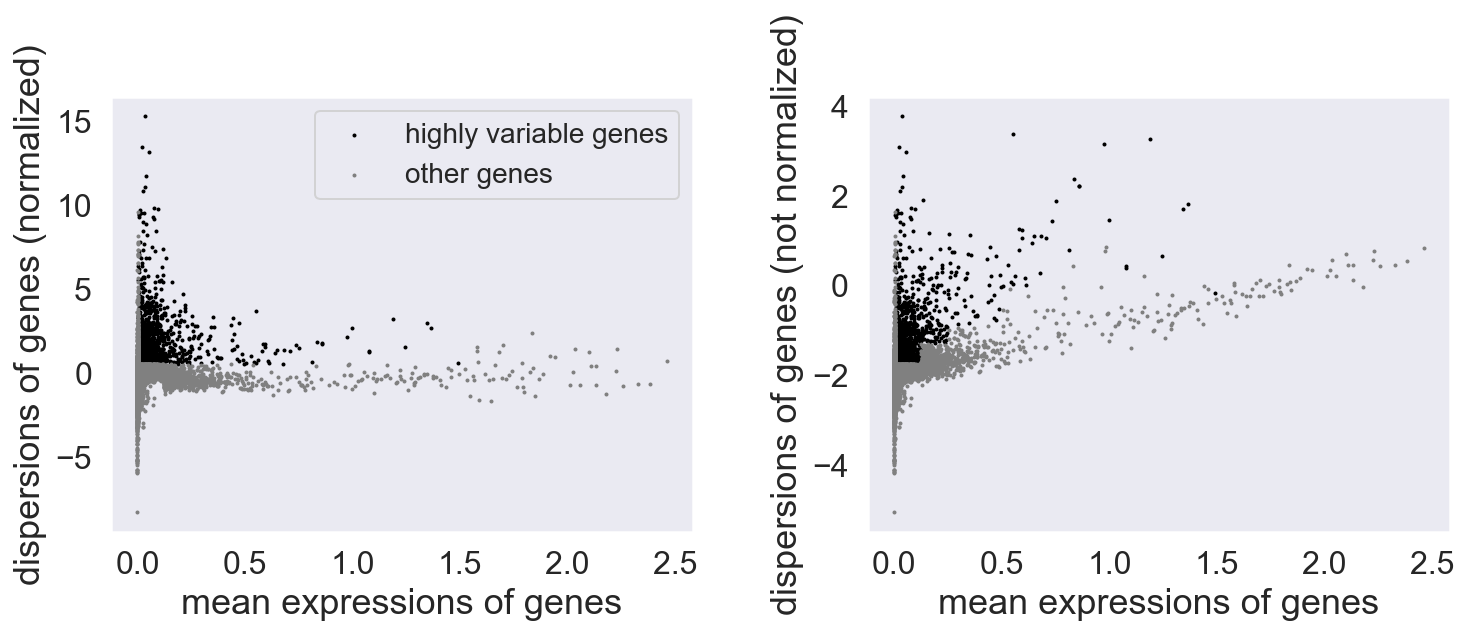

Trying to set attribute `.obs` of view, copying.


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


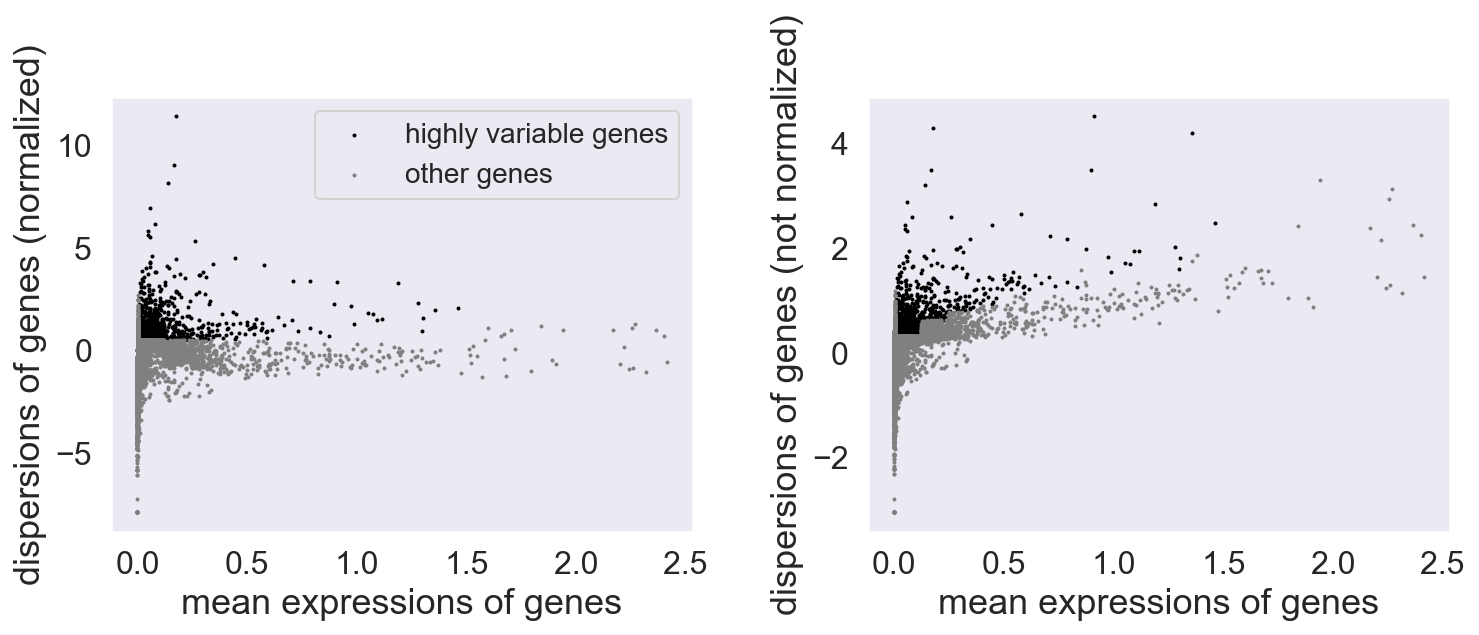

Trying to set attribute `.obs` of view, copying.


In [307]:
labels = annotate(adata)
adata.obs = adata.obs.join(labels)

sc.pp.normalize_total(adata, target_sum=1e3)
sc.pp.log1p(adata)

In [211]:
adata.obs.groupby("PredictedLabel").PredictedLabel.count()

PredictedLabel
B cell_score                           314
Basophil_score                         146
CD14+CD16+ monocyte_score              282
CD4+ T cell_score                      120
CD8+ T cell_score                      535
Eosinophil_score                       530
Granulocyte_score                      121
Macrophage_score                       670
Megakaryocyte progenitor cell_score     98
Natural killer T (NKT) cell_score      195
Natural killer cell_score              251
Plasma cell_score                       47
Plasmablast_score                      237
Platelet_score                         237
T cell_score                           834
Name: PredictedLabel, dtype: int64

In [212]:
adata.obs[adata.obs.COVID == 0].groupby("PredictedLabel").PredictedLabel.count()

PredictedLabel
B cell_score                            44
Basophil_score                          66
CD14+CD16+ monocyte_score               94
CD4+ T cell_score                       17
CD8+ T cell_score                      174
Eosinophil_score                       152
Granulocyte_score                       53
Macrophage_score                       243
Megakaryocyte progenitor cell_score     17
Natural killer T (NKT) cell_score       40
Natural killer cell_score              102
Plasma cell_score                       13
Plasmablast_score                      122
Platelet_score                          94
T cell_score                           185
Name: PredictedLabel, dtype: int64

... storing 'PredictedLabel' as categorical


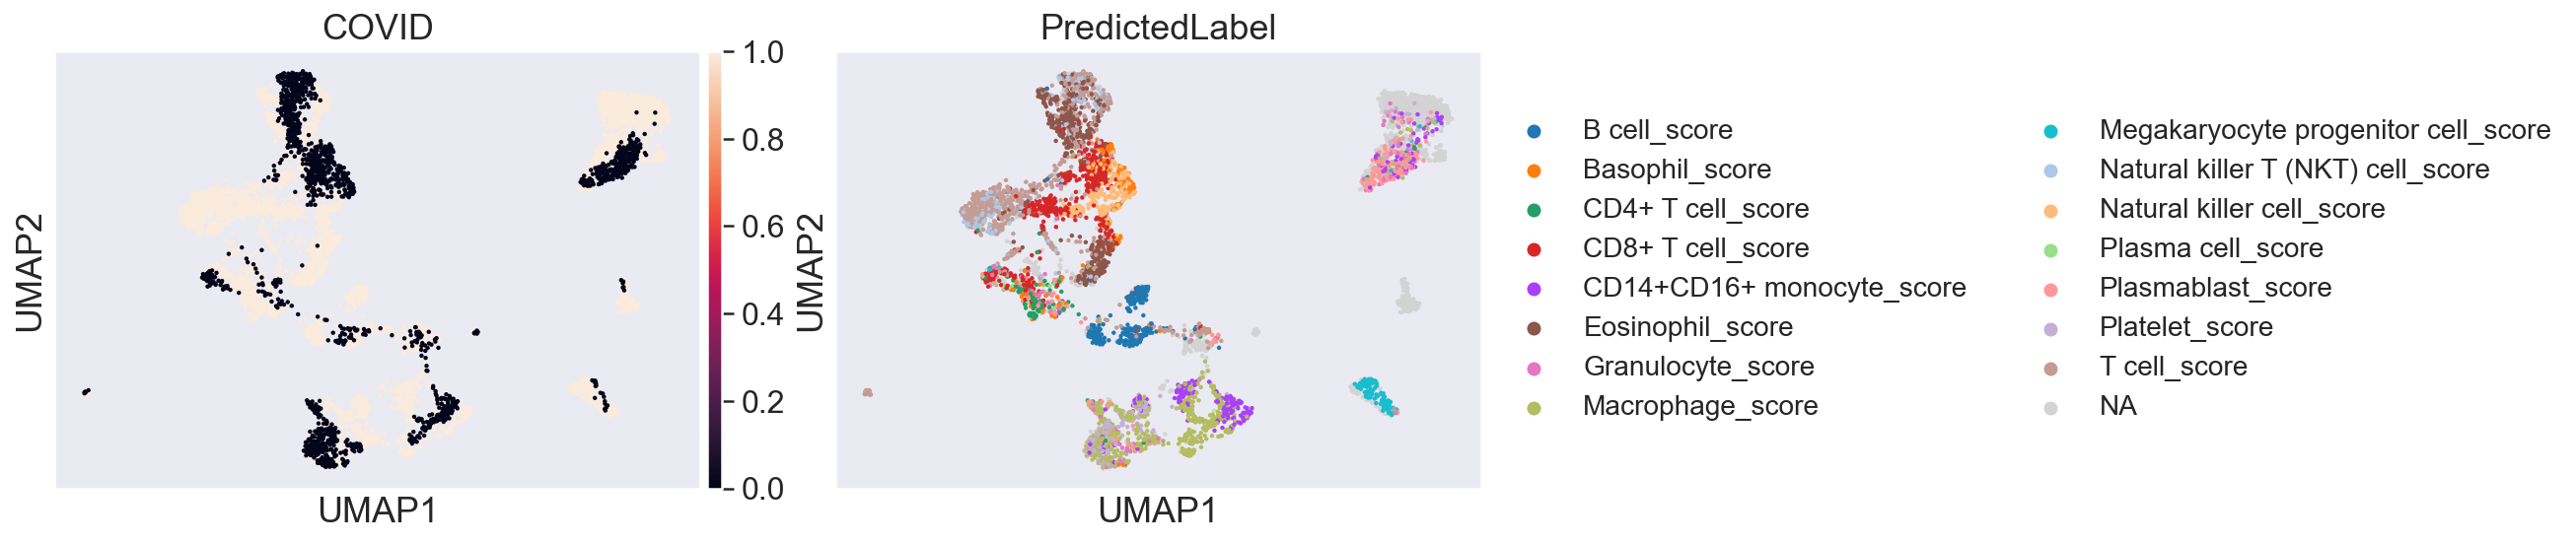

In [311]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=50)
sc.tl.umap(adata)#, init_pos='paga')
sc.pl.umap(adata, color=['COVID', 'PredictedLabel'], wspace=.1)

In [287]:
selected = []
for ctype, sub in adata.obs[adata.obs.COVID == 0].groupby('PredictedLabel'):
    sampled = sub.sample(n=np.min([50, sub.shape[0]]))
    selected += sampled.index.tolist()

balanced = adata[selected]


In [288]:
from sklearn.decomposition import NMF

In [289]:
from sklearn.metrics.pairwise import cosine_similarity

In [290]:
def similarity(H, adata_obs):
    nmf_cols = [c for c in H.columns if 'NMF' in c]
    sims = pd.DataFrame(cosine_similarity(H[nmf_cols].values), index=H.index, columns=H.index)
    sims.reset_index(inplace=True)
    sims.rename(columns={'index': 'CellName'}, inplace=True)
    sims = sims.melt(id_vars='CellName', var_name='comparison', value_name='similarity')

    sims = sims.join(adata_obs, on='CellName').join(adata_obs, on='comparison', rsuffix='_comparison')
    sims['Intra'] = ((sims[['PredictedLabel']].values == sims[['PredictedLabel_comparison']].values).sum(axis=1) == 1)
    sims = sims[sims.CellName != sims.comparison]
    return sims

In [399]:
l1 = 0.1
alpha = 10 ** - 9
for k in np.arange(adata.obs.PredictedLabel.nunique() - 10, adata.obs.PredictedLabel.nunique() + 5, 2):
    nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=0)
    H = nmf.fit_transform(balanced.X)
    H = pd.DataFrame(H, index=balanced.obs[balanced.obs.COVID == 0].index,
                     columns=['NMF' + str(i + 1) for i in range(k)])
    sim = similarity(H, balanced.obs)

    print(k)
    print(sim.groupby('Intra').similarity.mean())
    print(sim.groupby('Intra').similarity.mean().diff() / sim.groupby('Intra').similarity.mean().max() )
    print(H.sum(axis=0))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


5
Intra
False    0.389318
True     0.814828
Name: similarity, dtype: float32
Intra
False         NaN
True     0.522209
Name: similarity, dtype: float32
NMF1    275.240143
NMF2    184.693985
NMF3    208.353134
NMF4     63.061180
NMF5    169.546478
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


7
Intra
False    0.352768
True     0.754738
Name: similarity, dtype: float32
Intra
False         NaN
True     0.532596
Name: similarity, dtype: float32
NMF1    264.906250
NMF2    143.240677
NMF3    177.642395
NMF4     58.770981
NMF5    148.190750
NMF6    174.328491
NMF7    170.006607
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


9
Intra
False    0.328556
True     0.738565
Name: similarity, dtype: float32
Intra
False         NaN
True     0.555143
Name: similarity, dtype: float32
NMF1    245.259933
NMF2    136.338013
NMF3    160.739532
NMF4     55.265614
NMF5    135.245102
NMF6    181.159668
NMF7    156.919525
NMF8     61.572060
NMF9     89.368309
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


11
Intra
False    0.317944
True     0.724368
Name: similarity, dtype: float32
Intra
False         NaN
True     0.561074
Name: similarity, dtype: float32
NMF1     234.582977
NMF2     125.457474
NMF3     150.895767
NMF4      51.347195
NMF5     133.183640
NMF6     150.250305
NMF7     165.008591
NMF8      57.830551
NMF9      85.079506
NMF10     88.414192
NMF11     66.428543
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


13
Intra
False    0.281395
True     0.684712
Name: similarity, dtype: float32
Intra
False         NaN
True     0.589032
Name: similarity, dtype: float32
NMF1     221.859390
NMF2     111.752037
NMF3     128.275589
NMF4      49.262352
NMF5     132.730682
NMF6     146.026947
NMF7     160.910706
NMF8      78.450371
NMF9      65.133453
NMF10     84.453735
NMF11     65.902954
NMF12     95.911522
NMF13     78.568466
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


15
Intra
False    0.263290
True     0.663237
Name: similarity, dtype: float32
Intra
False         NaN
True     0.603023
Name: similarity, dtype: float32
NMF1     206.974899
NMF2      97.249100
NMF3     124.480522
NMF4      48.162960
NMF5     110.908630
NMF6     119.824791
NMF7     159.496643
NMF8      78.182320
NMF9      60.145817
NMF10     77.680412
NMF11     56.933193
NMF12     85.360748
NMF13     55.890598
NMF14     58.353024
NMF15    109.977951
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


17
Intra
False    0.261949
True     0.653035
Name: similarity, dtype: float32
Intra
False         NaN
True     0.598874
Name: similarity, dtype: float32
NMF1     211.337418
NMF2      89.692848
NMF3     125.037537
NMF4      48.518387
NMF5     129.722809
NMF6     115.629387
NMF7     146.617767
NMF8      81.686287
NMF9      66.443024
NMF10     96.034035
NMF11     25.384584
NMF12     84.750183
NMF13     56.411198
NMF14     41.418781
NMF15     94.045357
NMF16     71.204636
NMF17     31.664677
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


19
Intra
False    0.252741
True     0.634006
Name: similarity, dtype: float32
Intra
False         NaN
True     0.601359
Name: similarity, dtype: float32
NMF1     210.410583
NMF2      85.871841
NMF3     125.512726
NMF4      47.614311
NMF5     125.410568
NMF6     109.582321
NMF7     143.265137
NMF8      73.830917
NMF9      63.587933
NMF10     43.409054
NMF11     22.229500
NMF12     70.525993
NMF13     49.546299
NMF14     49.953560
NMF15     52.656033
NMF16    124.513832
NMF17     58.858067
NMF18     88.567055
NMF19     39.085251
dtype: float32


In [412]:
k = 14
for alpha in np.logspace(-9, -7, 8):
    nmf = NMF(n_components=k, l1_ratio=0.1, max_iter=1000, alpha_H=alpha, alpha_W=0)
    H = nmf.fit_transform(balanced.X)
    H = pd.DataFrame(H, index=balanced.obs[balanced.obs.COVID == 0].index,
                     columns=['NMF' + str(i + 1) for i in range(k)])
    sim = similarity(H, balanced.obs)
    
    print(alpha)
    print(sim.groupby('Intra').similarity.mean())
    print(sim.groupby('Intra').similarity.mean().diff() / sim.groupby('Intra').similarity.mean().max() )


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1e-09
Intra
False    0.278654
True     0.684882
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593135
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1.9306977288832536e-09
Intra
False    0.278935
True     0.685451
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593064
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


3.727593720314938e-09
Intra
False    0.278490
True     0.684966
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593426
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


7.1968567300115284e-09
Intra
False    0.278818
True     0.685619
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593334
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1.389495494373136e-08
Intra
False    0.278826
True     0.685124
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593029
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


2.682695795279727e-08
Intra
False    0.273946
True     0.669945
Name: similarity, dtype: float32
Intra
False         NaN
True     0.591092
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


5.1794746792312124e-08
Intra
False    0.278527
True     0.684796
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593271
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1e-07
Intra
False    0.273736
True     0.669704
Name: similarity, dtype: float32
Intra
False         NaN
True     0.591258
Name: similarity, dtype: float32


In [414]:
alpha = 10 ** -8
for l1 in np.logspace(-2, 0, 5):
    nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=0)
    H = nmf.fit_transform(balanced.X)
    H = pd.DataFrame(H, index=balanced.obs[balanced.obs.COVID == 0].index,
                     columns=['NMF' + str(i + 1) for i in range(k)])
    sim = similarity(H, balanced.obs)
    
    print(l1)
    print(sim.groupby('Intra').similarity.mean())
    print(sim.groupby('Intra').similarity.mean().diff() / sim.groupby('Intra').similarity.mean().max() )
    print(H.sum(axis=0))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


0.01
Intra
False    0.277745
True     0.678341
Name: similarity, dtype: float32
Intra
False         NaN
True     0.590552
Name: similarity, dtype: float32
NMF1     214.525375
NMF2     108.098679
NMF3     126.016571
NMF4      48.327625
NMF5     127.162880
NMF6     120.934029
NMF7     158.728394
NMF8      71.739273
NMF9      73.706261
NMF10     81.632408
NMF11     33.168732
NMF12     69.415741
NMF13     68.299522
NMF14     58.336128
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


0.03162277660168379
Intra
False    0.273879
True     0.670175
Name: similarity, dtype: float32
Intra
False         NaN
True     0.591332
Name: similarity, dtype: float32
NMF1     217.926285
NMF2     102.707733
NMF3     128.313263
NMF4      49.647270
NMF5     133.276215
NMF6     122.461021
NMF7     155.992081
NMF8      82.270142
NMF9      61.345390
NMF10    108.941948
NMF11     64.850708
NMF12     86.533226
NMF13     70.135681
NMF14     63.859390
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


0.1
Intra
False    0.278548
True     0.684432
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593023
Name: similarity, dtype: float32
NMF1     219.299866
NMF2     109.625374
NMF3     126.675064
NMF4      48.651985
NMF5     129.369232
NMF6     140.931900
NMF7     157.864227
NMF8      77.782463
NMF9      67.584564
NMF10     84.477852
NMF11     28.125305
NMF12     93.464104
NMF13     76.534943
NMF14     59.353542
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


0.31622776601683794
Intra
False    0.278409
True     0.684600
Name: similarity, dtype: float32
Intra
False         NaN
True     0.593326
Name: similarity, dtype: float32
NMF1     218.937912
NMF2     110.720695
NMF3     126.573265
NMF4      48.617985
NMF5     129.527222
NMF6     141.907272
NMF7     157.718048
NMF8      77.703903
NMF9      66.388832
NMF10     85.310982
NMF11     28.096987
NMF12     96.801758
NMF13     77.070831
NMF14     56.207741
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1.0
Intra
False    0.278756
True     0.685492
Name: similarity, dtype: float32
Intra
False        NaN
True     0.59335
Name: similarity, dtype: float32
NMF1     218.298416
NMF2     110.225548
NMF3     126.461685
NMF4      48.513248
NMF5     129.170746
NMF6     140.862793
NMF7     157.230331
NMF8      77.540428
NMF9      66.417778
NMF10     84.918236
NMF11     27.933256
NMF12     92.937286
NMF13     74.104042
NMF14     50.044815
dtype: float32


In [422]:
l1 = 0.1
nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=alpha)
H = nmf.fit_transform(balanced.X)
H = pd.DataFrame(H, index=balanced.obs[balanced.obs.COVID == 0].index,
                 columns=['NMF' + str(i + 1) for i in range(k)])

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


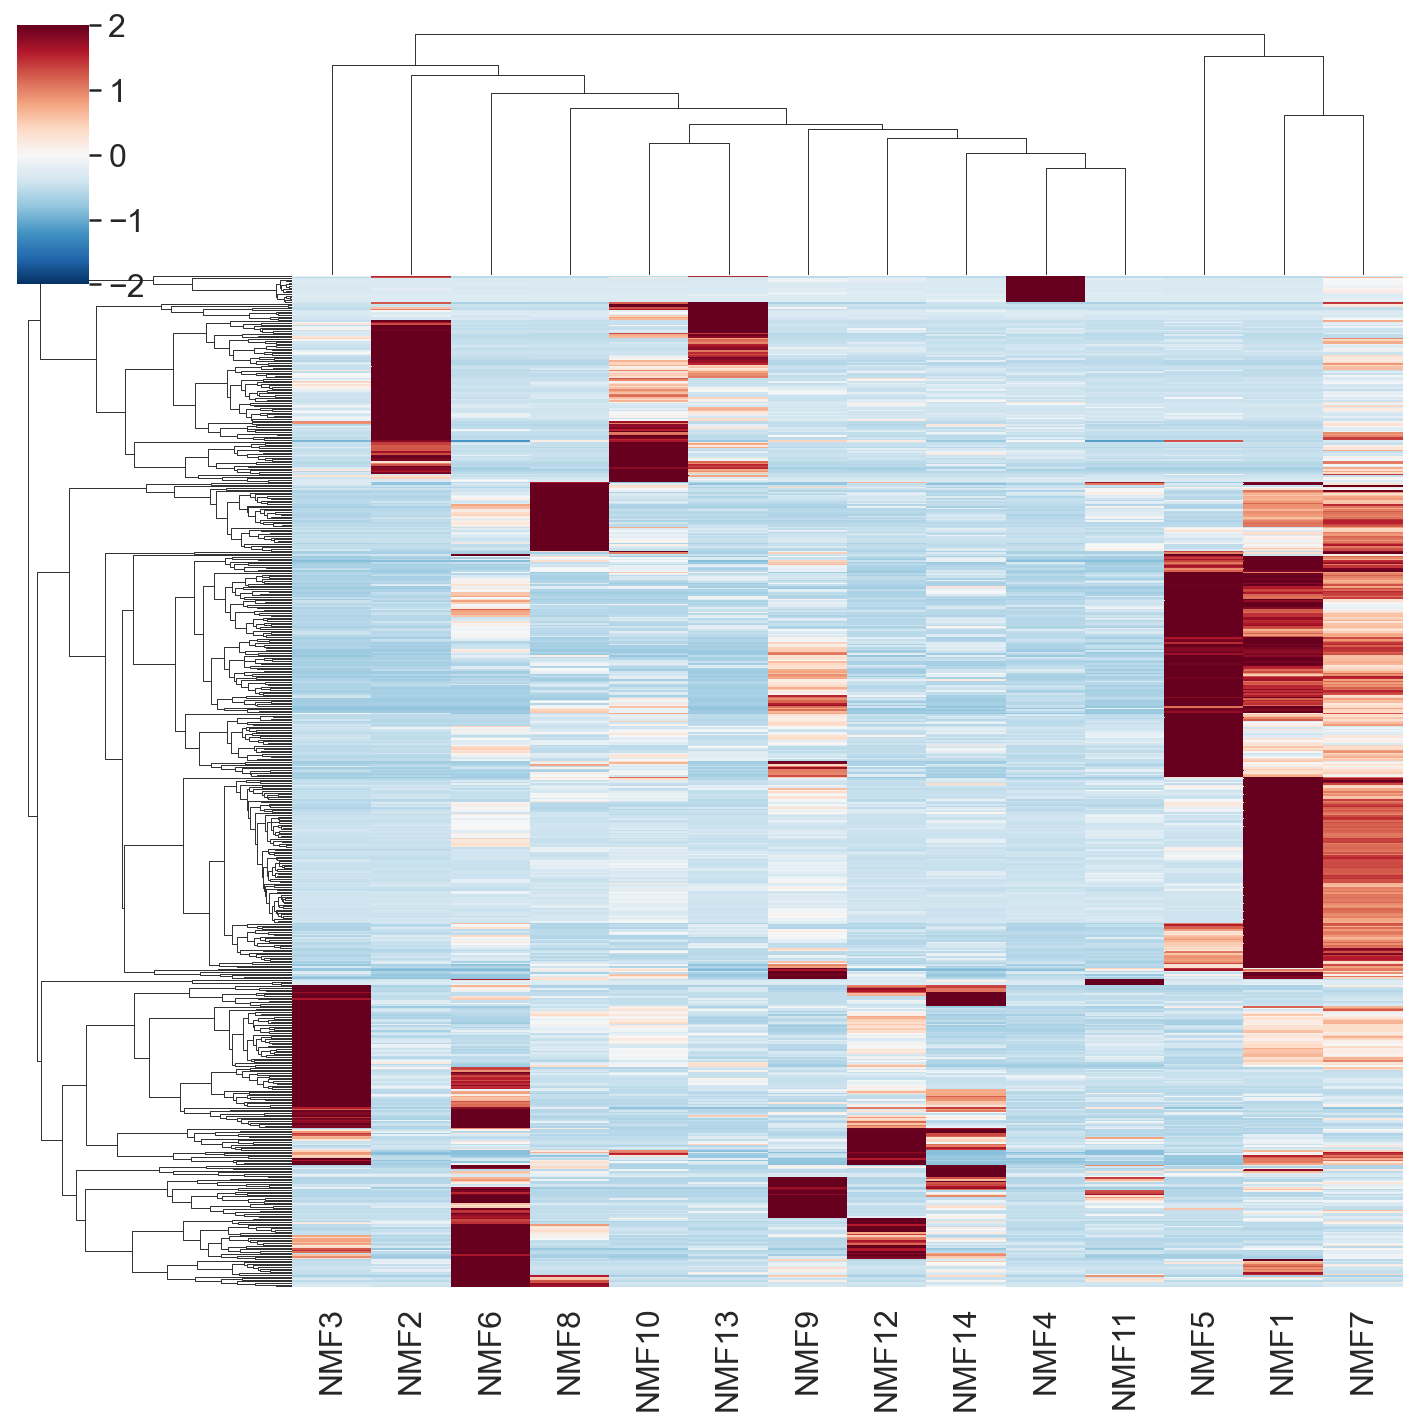

In [423]:
sns.clustermap(H[[c for c in H.columns if 'NMF' in c]], z_score=0, cmap='RdBu_r', center=0, vmax=2, vmin=-2, yticklabels=False)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


0.0 3.0826948


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


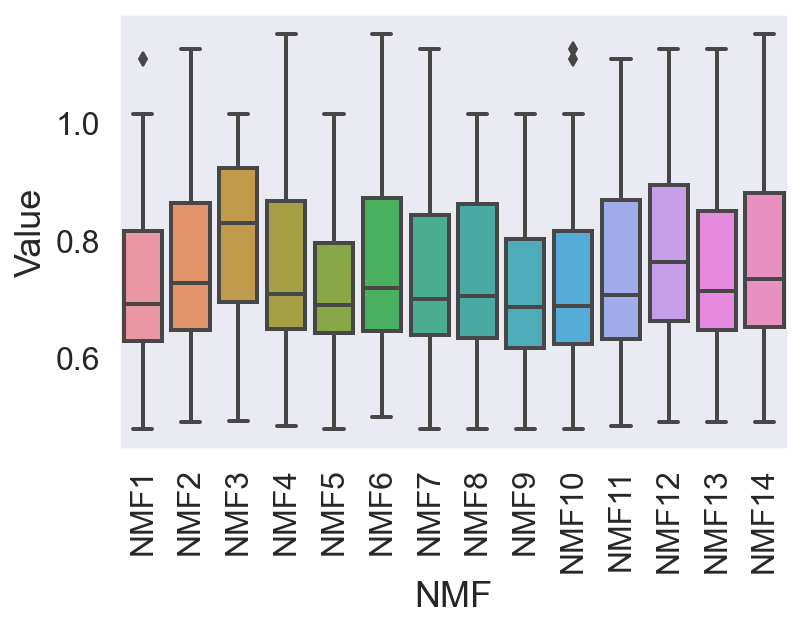

In [418]:
l1 = 0.3
alpha = 10 ** - 7
k = 14
nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=alpha)
H = nmf.fit_transform(balanced.X)
print(H.min(), H.max())
# H = np.log(H + 10 ** -10)
# H = np.log(H / nmf.components_.sum(axis=1) * 100 + 10 ** -10)
H = np.log(H / (H / H.sum(axis=1)[:, np.newaxis]) + 10 ** -10)
H = pd.DataFrame(H, index=balanced.obs.index,
                 columns=['NMF' + str(i + 1) for i in range(k)])

tidyH = H.reset_index().rename(columns={'index': 'cell'}).melt(id_vars='cell', var_name='NMF', value_name='Value')
tidyH = tidyH.join(adata.obs, on='cell')

sns.boxplot(x='NMF', y='Value', data=tidyH)
_ = plt.xticks(rotation=90)

In [486]:
# top = np.percentile(nmf.components_, q=90, axis=1)
# top_hits = (nmf.components_ > top[:, np.newaxis]).sum(axis=0)
# top_genes = adata.var_names[np.where(top_hits >= 1)]

def fit_model_and_plot(data, nmf=nmf, plot=[], suffix='', **kwargs):
    adata = data.copy()
    H = nmf.transform(adata.X)
    H = np.log(H / np.sum(H, axis=1)[:, np.newaxis] + 10 ** -10)
    H = pd.DataFrame(H, index=adata.obs.index,
                     columns=['NMF' + str(i + 1) + suffix for i in range(H.shape[1])])
    adata.obs = adata.obs.join(H)
    adata.obs.COVID = adata.obs.COVID.astype('category')
    
    for p in plot:
        sc.pl.umap(adata, color=p, wspace=.15, cmap='inferno', **kwargs)
#     sc.pl.umap(adata, color=['NMF3' + suffix, 'NMF4'  + suffix, 'NMF5'  + suffix], wspace=.15, cmap='inferno')
#     sc.pl.umap(adata, color=['NMF6' + suffix, 'NMF7'  + suffix, 'NMF8'  + suffix], wspace=.15, cmap='inferno') 

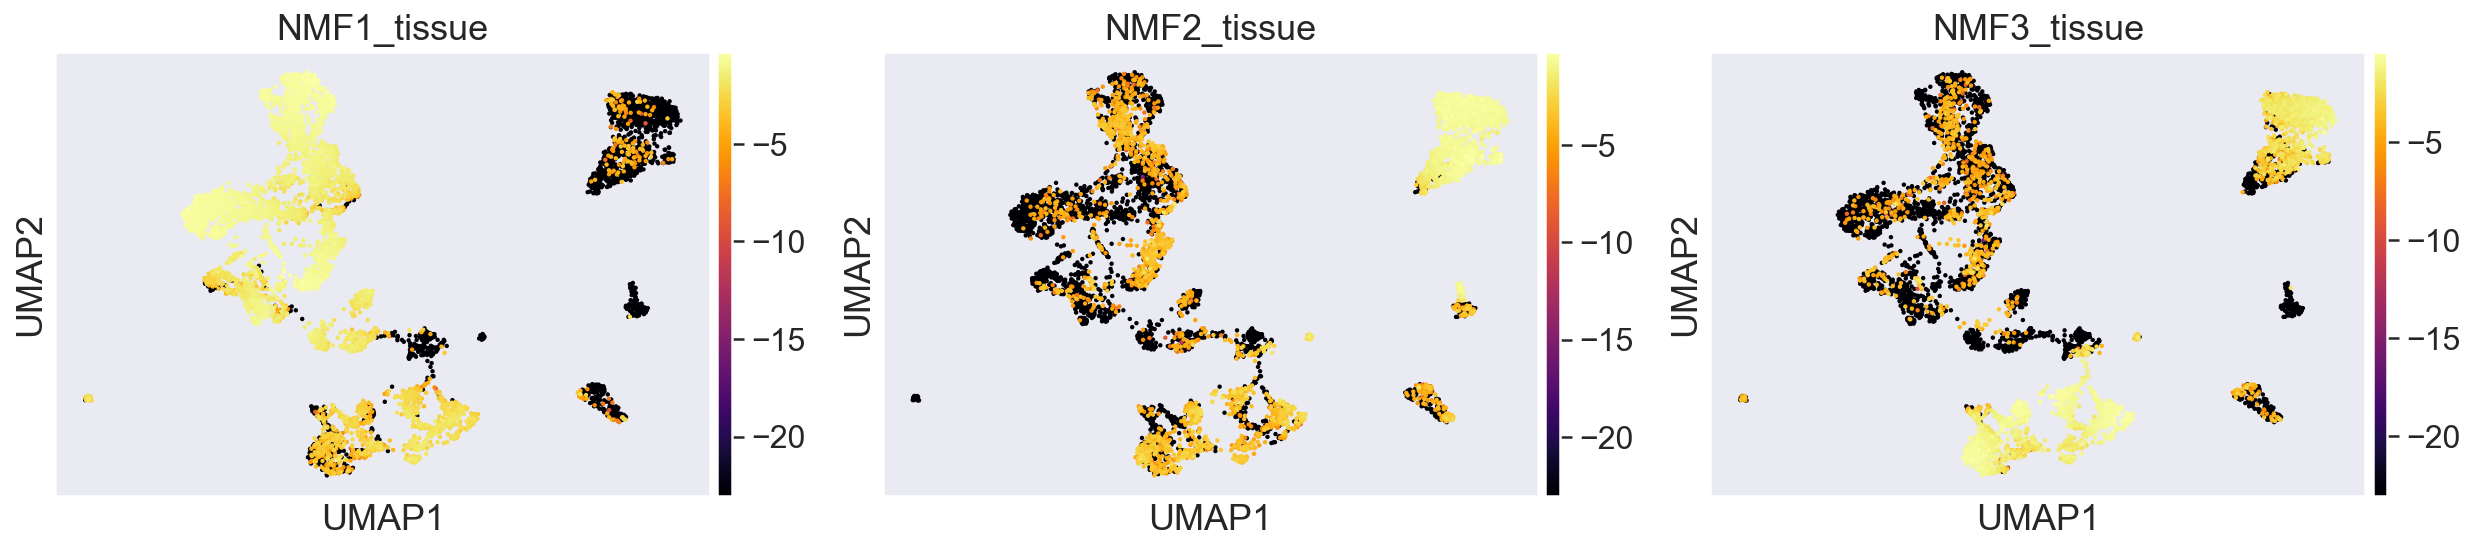

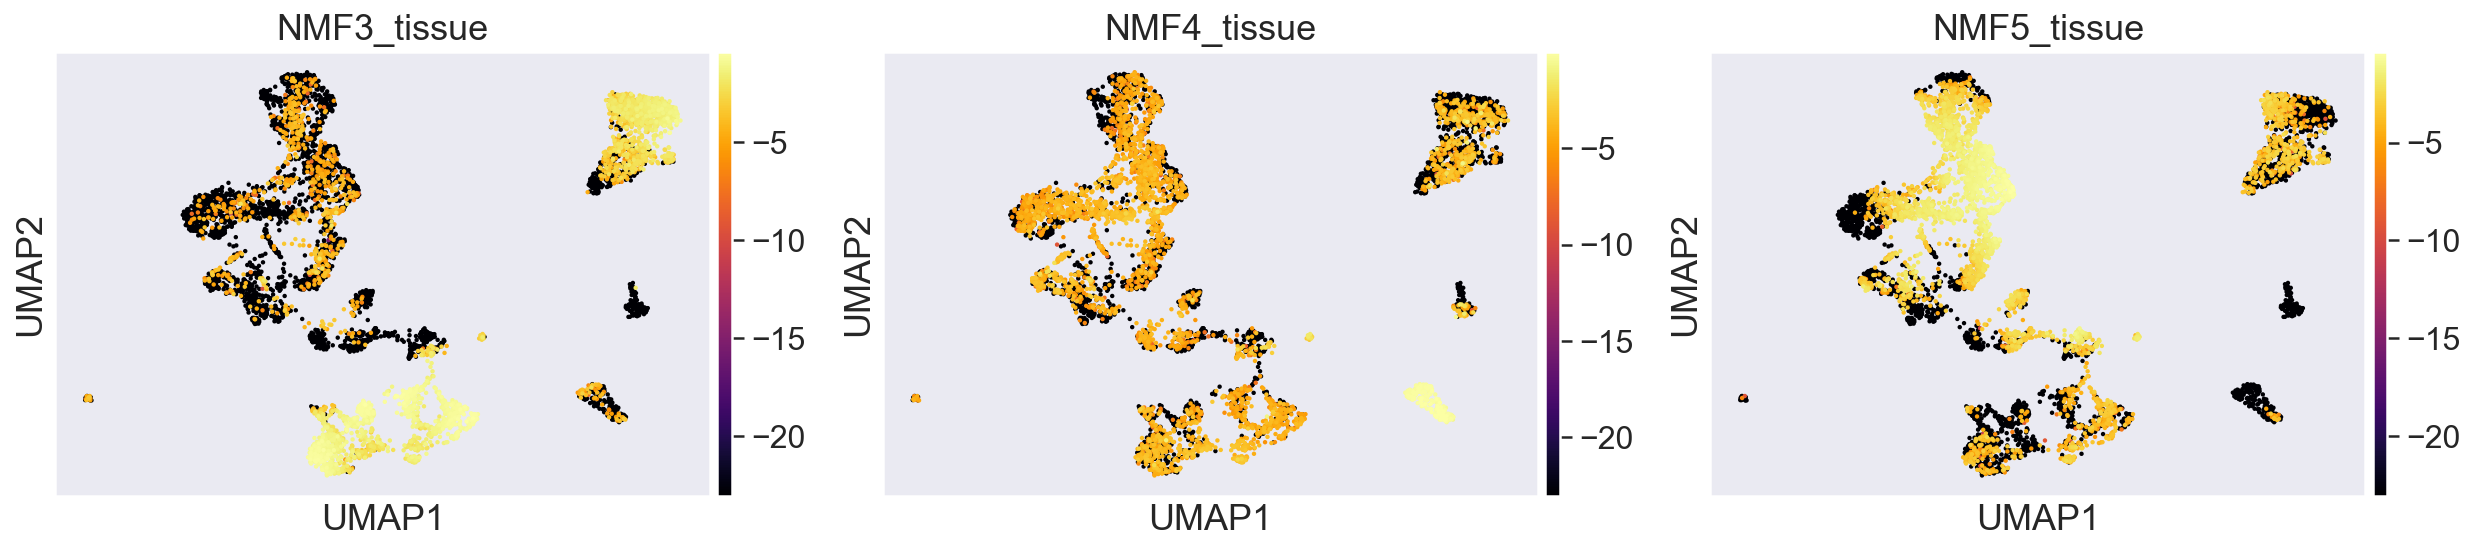

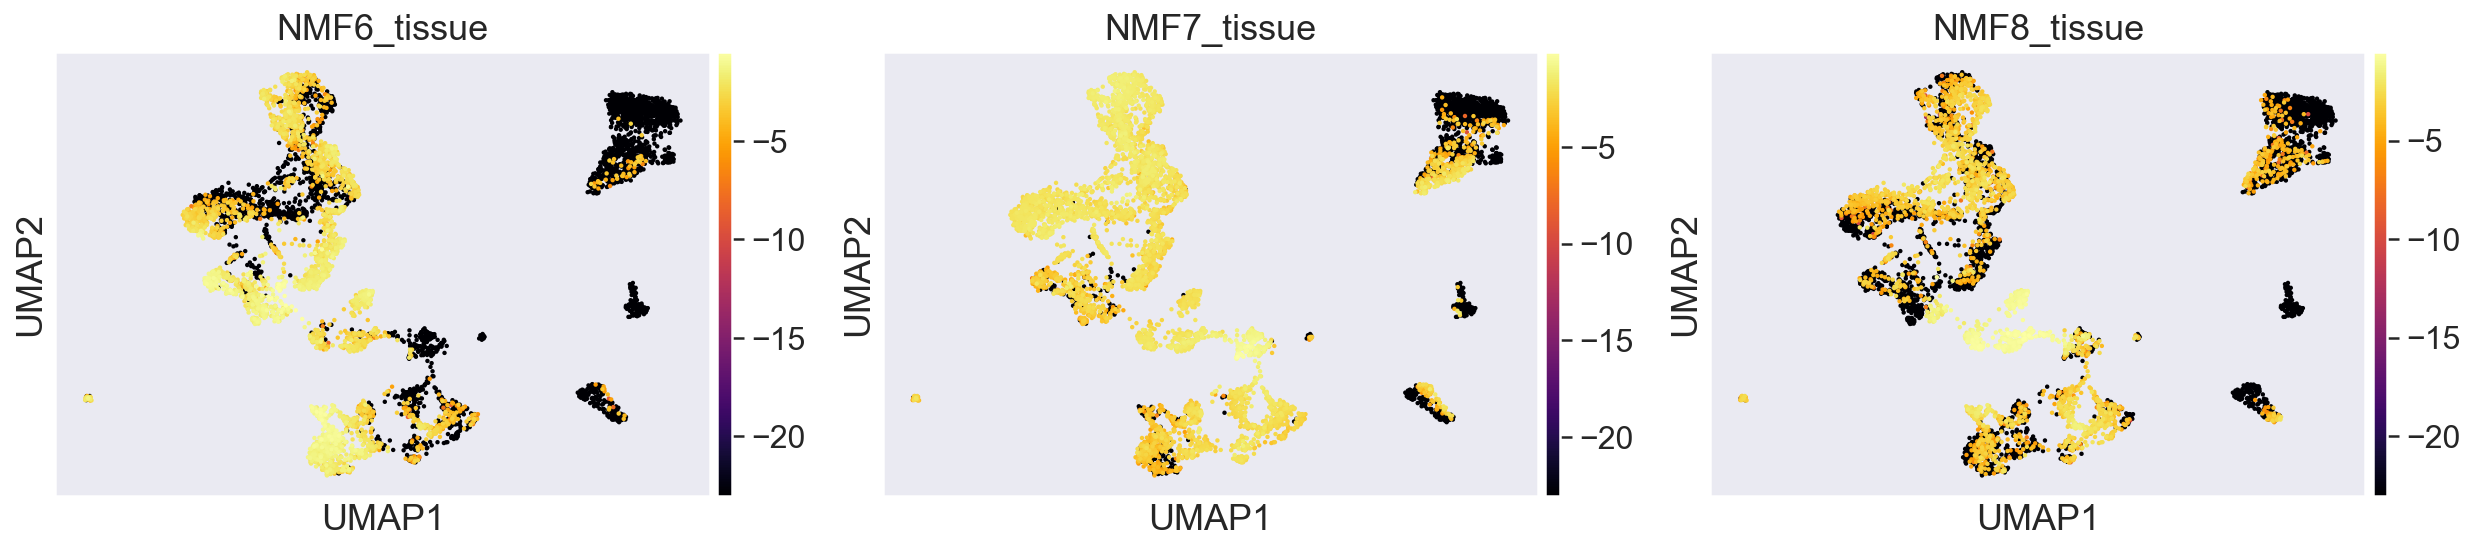

In [420]:
plot = [['NMF1', 'NMF2', 'NMF3'], ['NMF4', 'NMF5', 'NMF6'], ['NMF7', 'NMF8', 'NMF9']]
plot = [p + '_tissue' for p in plot]
fit_model_and_plot(adata, suffix='_tissue')

# sns.boxplot(x='NMF', y='Value', hue='COVID', data=tidyH)
# plt.ylim(10 ** -5, 2)
# plt.yscale('log')
# # plt.xticks(rotation=90)

In [445]:
selected = []
for ctype, sub in adata.obs.groupby(['PredictedLabel', 'COVID']):
    sampled = sub.sample(n=np.min([100, sub.shape[0]]))
    selected += sampled.index.tolist()

not_excluded = adata.var_names[np.where(top_hits < 1)]
balanced = adata[selected, not_excluded]


In [446]:
def similarity(H, adata_obs):
    nmf_cols = [c for c in H.columns if 'NMF' in c]
    sims = pd.DataFrame(cosine_similarity(H[nmf_cols].values), index=H.index, columns=H.index)
    sims.reset_index(inplace=True)
    sims.rename(columns={'index': 'CellName'}, inplace=True)
    sims = sims.melt(id_vars='CellName', var_name='comparison', value_name='similarity')

    sims = sims.join(adata_obs, on='CellName').join(adata_obs, on='comparison', rsuffix='_comparison')
    sims['Intra'] = ((sims[['PredictedLabel', 'COVID']].values == sims[['PredictedLabel_comparison', 'COVID_comparison']].values).sum(axis=1) == 2)
    sims = sims[sims.CellName != sims.comparison]
    return sims

l1 = 0.3
alpha = 0
for k in np.arange(2, 10):
    nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=0)
    H = nmf.fit_transform(balanced.X)
    H = pd.DataFrame(H, index=balanced.obs.index,
                     columns=['NMF' + str(i + 1) for i in range(k)])
    sim = similarity(H, balanced.obs)
    
    print(k)
    print(sim.groupby('Intra').similarity.mean())
    print(sim.groupby('Intra').similarity.mean().diff() / sim.groupby('Intra').similarity.mean().max() )
    print(H.sum(axis=0))

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


2
Intra
False    0.731009
True     0.925334
Name: similarity, dtype: float32
Intra
False         NaN
True     0.210006
Name: similarity, dtype: float32
NMF1    1014.862366
NMF2     633.872192
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


3
Intra
False    0.677004
True     0.885253
Name: similarity, dtype: float32
Intra
False         NaN
True     0.235242
Name: similarity, dtype: float32
NMF1    998.770813
NMF2    516.486328
NMF3    359.795410
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


4
Intra
False    0.638373
True     0.897858
Name: similarity, dtype: float32
Intra
False         NaN
True     0.289004
Name: similarity, dtype: float32
NMF1    921.944702
NMF2    429.996460
NMF3    216.463043
NMF4    411.332031
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


5
Intra
False    0.493183
True     0.833177
Name: similarity, dtype: float32
Intra
False        NaN
True     0.40807
Name: similarity, dtype: float32
NMF1    775.359253
NMF2    565.002014
NMF3    152.155701
NMF4    274.835449
NMF5    442.452301
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


6
Intra
False    0.450877
True     0.814191
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446228
Name: similarity, dtype: float32
NMF1    687.687805
NMF2    309.572937
NMF3    152.289795
NMF4    384.402893
NMF5    330.216766
NMF6    830.561279
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


7
Intra
False    0.454279
True     0.794087
Name: similarity, dtype: float32
Intra
False         NaN
True     0.427923
Name: similarity, dtype: float32
NMF1    644.182190
NMF2    271.816864
NMF3    151.635803
NMF4    402.604797
NMF5    298.393555
NMF6    760.441589
NMF7    414.395233
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


8
Intra
False    0.457853
True     0.777749
Name: similarity, dtype: float32
Intra
False        NaN
True     0.41131
Name: similarity, dtype: float32
NMF1    647.833252
NMF2    261.996613
NMF3    147.112411
NMF4    362.271210
NMF5    292.177734
NMF6    721.105530
NMF7    342.485565
NMF8    325.434509
dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


9
Intra
False    0.446155
True     0.762025
Name: similarity, dtype: float32
Intra
False         NaN
True     0.414514
Name: similarity, dtype: float32
NMF1    648.103394
NMF2    249.324173
NMF3    144.329910
NMF4    349.123871
NMF5    276.097748
NMF6    671.926880
NMF7    326.609863
NMF8    300.253235
NMF9    182.082062
dtype: float32


In [447]:
k = 6
for alpha in np.logspace(-8, -5, 8):
    nmf = NMF(n_components=k, l1_ratio=l1, max_iter=1000, alpha_H=alpha, alpha_W=0)
    H = nmf.fit_transform(balanced.X)
    H = pd.DataFrame(H, index=balanced.obs.index,
                     columns=['NMF' + str(i + 1) for i in range(k)])
    sim = similarity(H, balanced.obs)
    
    print(alpha)
    print(sim.groupby('Intra').similarity.mean())
    print(sim.groupby('Intra').similarity.mean().diff() / sim.groupby('Intra').similarity.mean().max() )


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1e-08
Intra
False    0.450877
True     0.814192
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446227
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


2.682695795279727e-08
Intra
False    0.450878
True     0.814192
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446226
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


7.196856730011513e-08
Intra
False    0.450881
True     0.814193
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446223
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1.9306977288832497e-07
Intra
False    0.450874
True     0.814189
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446229
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


5.179474679231213e-07
Intra
False    0.45086
True     0.81418
Name: similarity, dtype: float32
Intra
False        NaN
True     0.44624
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


1.389495494373136e-06
Intra
False    0.450703
True     0.814100
Name: similarity, dtype: float32
Intra
False         NaN
True     0.446378
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


3.727593720314938e-06
Intra
False    0.451351
True     0.814200
Name: similarity, dtype: float32
Intra
False         NaN
True     0.445651
Name: similarity, dtype: float32


/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  ConvergenceWarning,


1e-05
Intra
False    0.453035
True     0.814611
Name: similarity, dtype: float32
Intra
False         NaN
True     0.443863
Name: similarity, dtype: float32


In [459]:
k = 6
alpha = 3 * 10 ** - 6
nmf = NMF(n_components=k, l1_ratio=0.3, max_iter=5000, alpha_H=alpha, alpha_W=0)
H = nmf.fit_transform(balanced.X)
H = pd.DataFrame(H, index=balanced.obs.index,
                 columns=['NMF' + str(i + 1) for i in range(k)])

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [450]:
top = np.percentile(nmf.components_, q=90, axis=1)
top_hits = (nmf.components_ > top[:, np.newaxis]).sum(axis=0)
top_genes = adata.var_names[np.where(top_hits >= 1)]
print(top_genes)

Index(['SCYL3', 'FUCA2', 'GCLC', 'NFYA', 'ENPP4', 'RAD52', 'LAP3', 'MAD1L1',
       'LASP1', 'KLHL13',
       ...
       'PGGT1B', 'CCDC112', 'ANKRD33B', 'WDR41', 'NDUFS4', 'SCGB3A2', 'TIGD6',
       'SERINC5', 'EBF1', 'GFM2'],
      dtype='object', name='hgnc_symbol', length=2766)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'NMF1'),
  Text(1, 0, 'NMF2'),
  Text(2, 0, 'NMF3'),
  Text(3, 0, 'NMF4'),
  Text(4, 0, 'NMF5'),
  Text(5, 0, 'NMF6')])

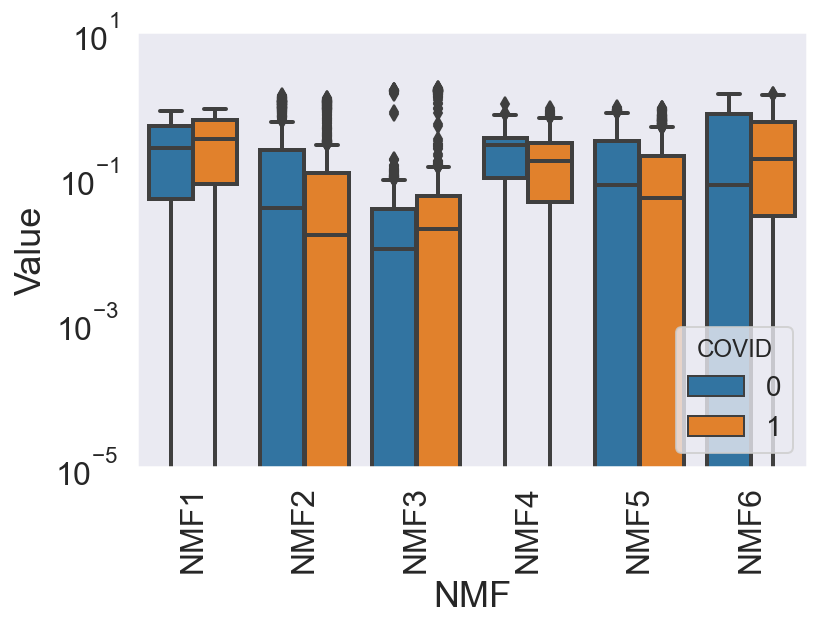

In [451]:
tidyH = H.reset_index().rename(columns={'index': 'cell'}).melt(id_vars='cell', var_name='NMF', value_name='Value')
tidyH = tidyH.join(adata.obs, on='cell')

sns.boxplot(x='NMF', y='Value', hue='COVID', data=tidyH)
plt.ylim(10 ** -5, 10)
plt.yscale('log')
plt.xticks(rotation=90)

In [452]:
enrich = sc.queries.enrich(top_genes.tolist(), gprofiler_kwargs={'background': not_excluded.tolist()})
for k, group in enrich.groupby('source'):
    print(k)
    print(group[['name', 'p_value']])
    print('\n\n')

CORUM
          name   p_value
57  CORUM root  0.002734



GO:BP
                  name   p_value
14    cellular process  0.000033
32  biological_process  0.000450



GO:CC
                                  name   p_value
18  intracellular anatomical structure  0.000107
56                           cytoplasm  0.002479
93                           organelle  0.020766



GO:MF
                  name   p_value
77  molecular_function  0.008279
85     protein binding  0.014582



HPA
                                               name   p_value
0                                          HPA root  0.000001
1                                            testis  0.000001
2                                           caudate  0.000002
3                     caudate; neuronal cells[≥Low]  0.000002
4                                         stomach 2  0.000004
..                                              ...       ...
103               breast; myoepithelial cells[≥Low]  0.031416
104                c

In [519]:
assignments = (nmf.components_ / nmf.components_.sum(axis=1)[:, np.newaxis]).argmax(axis=0)

accept = np.percentile(nmf.components_, q=99, axis=1)
accept_hits = (nmf.components_ > accept[:, np.newaxis]).sum(axis=0)
accept_genes = accept_hits >= 1

balanced.var['NMF'] = assignments
balanced.var['accept'] = accept_genes

In [523]:
for k, data in balanced.var[balanced.var.accept].groupby('NMF'):
    print(k, len(data))
    enrich = sc.queries.enrich(data.index.tolist(), gprofiler_kwargs={'background': not_excluded.tolist()})
    for k2, group in enrich.groupby('source'):
        if k2 in ['GO:CC', 'GO:MF', 'HP', 'HPA', 'MIRNA', 'TF']:
            continue
        print(k2)
        print(group[['name', 'p_value']].head())
    print('######################################')
    print('######################################')
    print('\n\n')
    

0 70
CORUM
                                  name        p_value
2                Ribosome, cytoplasmic  5.747561e-121
44  Nop56p-associated pre-rRNA complex   7.315994e-80
53  60S ribosomal subunit, cytoplasmic   1.670136e-65
83  40S ribosomal subunit, cytoplasmic   7.745579e-47
86  40S ribosomal subunit, cytoplasmic   1.514024e-44
GO:BP
                                                 name        p_value
9   SRP-dependent cotranslational protein targetin...  1.538992e-108
12      cotranslational protein targeting to membrane  2.898411e-106
13                            protein targeting to ER  1.446521e-105
19  establishment of protein localization to endop...  3.034686e-104
25  nuclear-transcribed mRNA catabolic process, no...   9.997181e-99
KEGG
                               name        p_value
14                         Ribosome  4.336011e-105
34   Coronavirus disease - COVID-19   5.550360e-89
167                  KEGG root term   2.709696e-16
REAC
                               

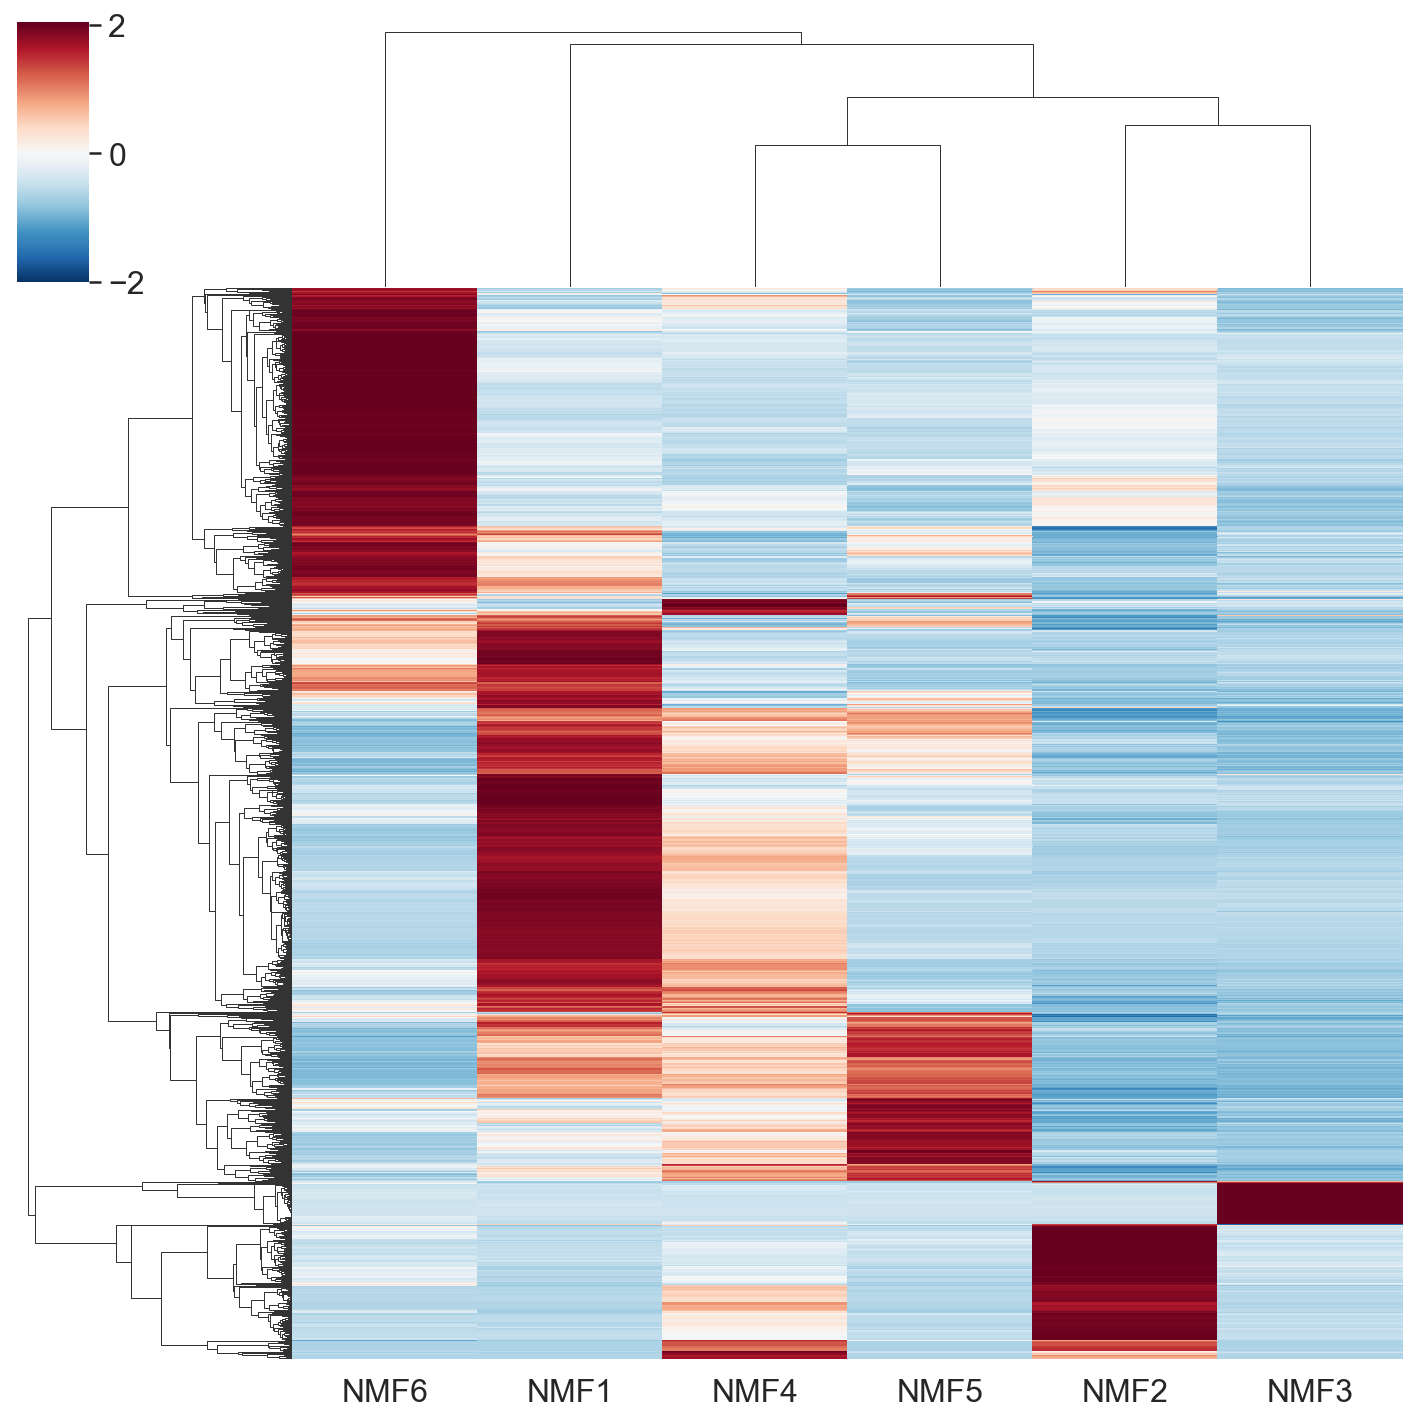

In [454]:
sns.clustermap(H[[c for c in H.columns if 'NMF' in c]] + np.random.normal(0, 10 ** -10, 6)[np.newaxis, :],
               z_score=0, cmap='RdBu_r', center=0, vmin=-2, yticklabels=False)

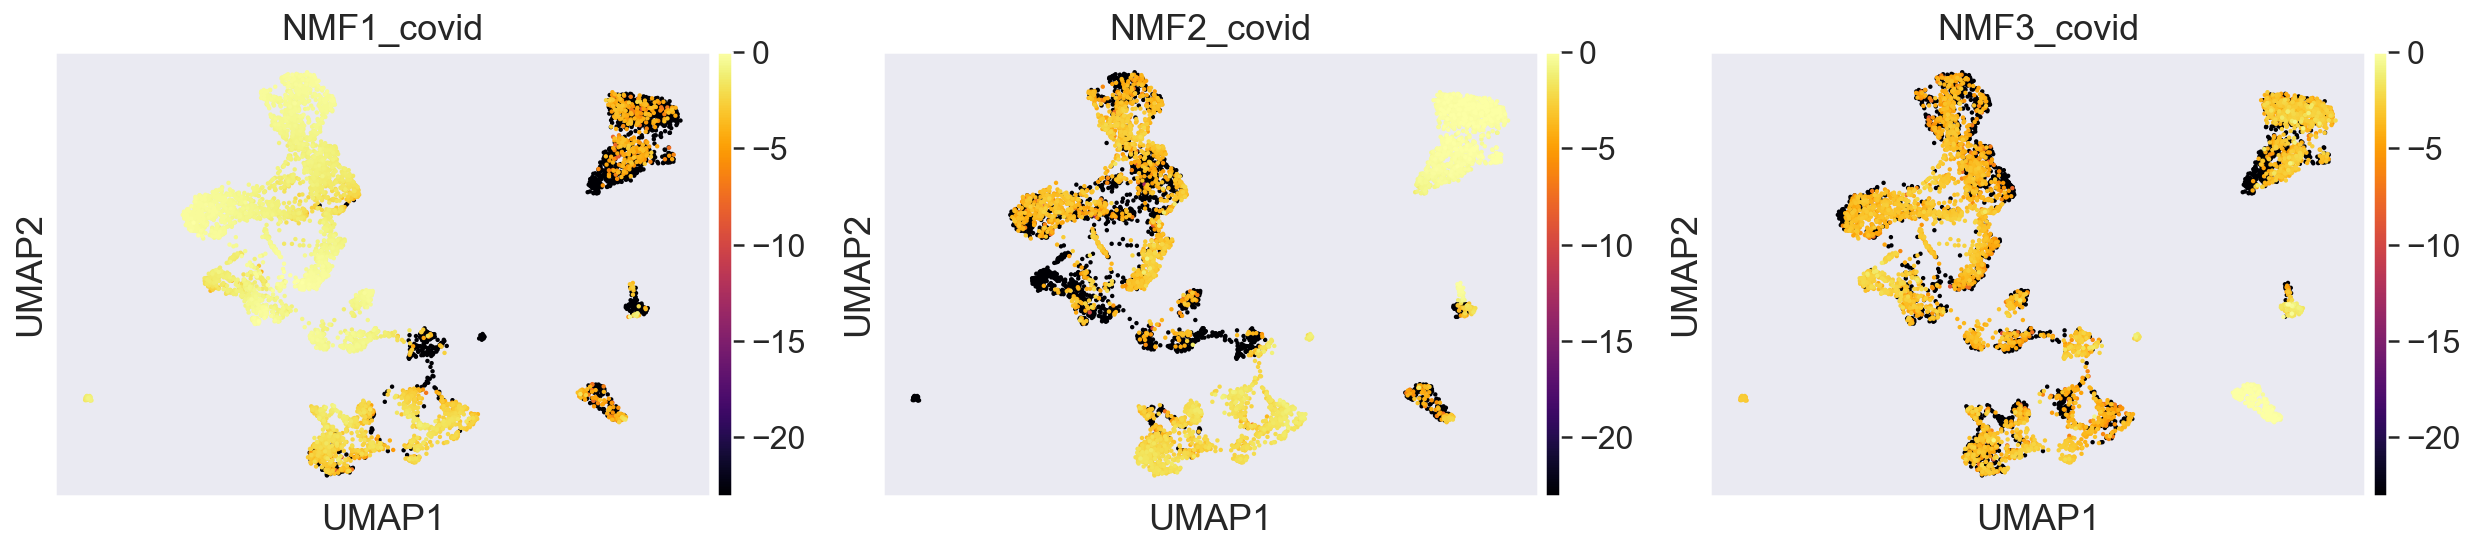

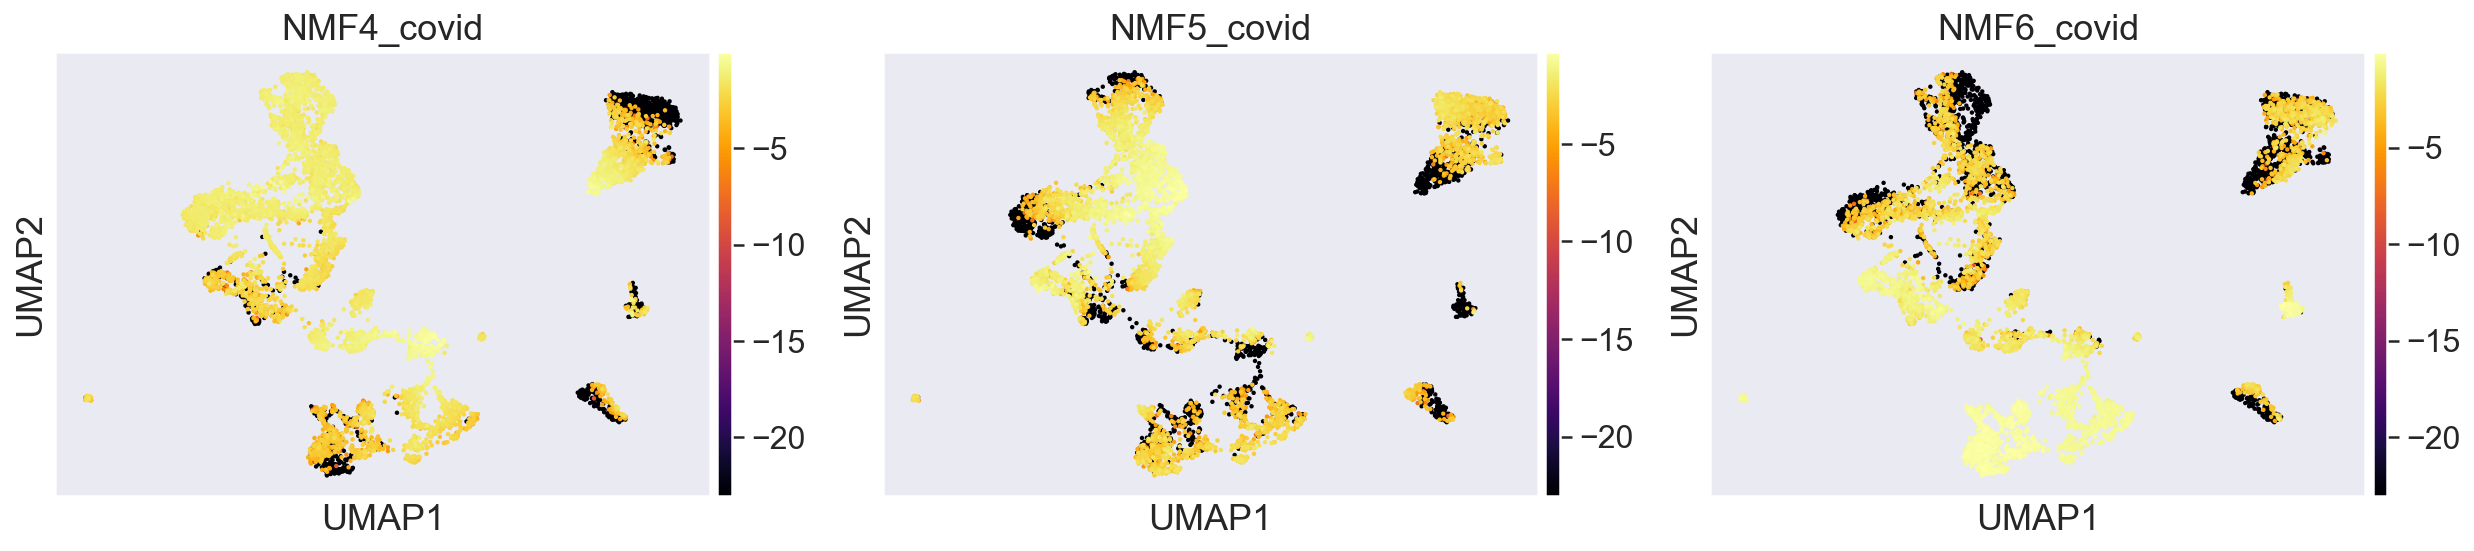

In [461]:
plot = [['NMF1', 'NMF2', 'NMF3'], ['NMF4', 'NMF5', 'NMF6']]
plot = [[pi + '_covid' for pi in p] for p in plot]
# fit_model_and_plot(adata, suffix='_tissue')
fit_model_and_plot(adata[:, not_excluded], suffix='_covid', plot=plot, nmf=nmf)

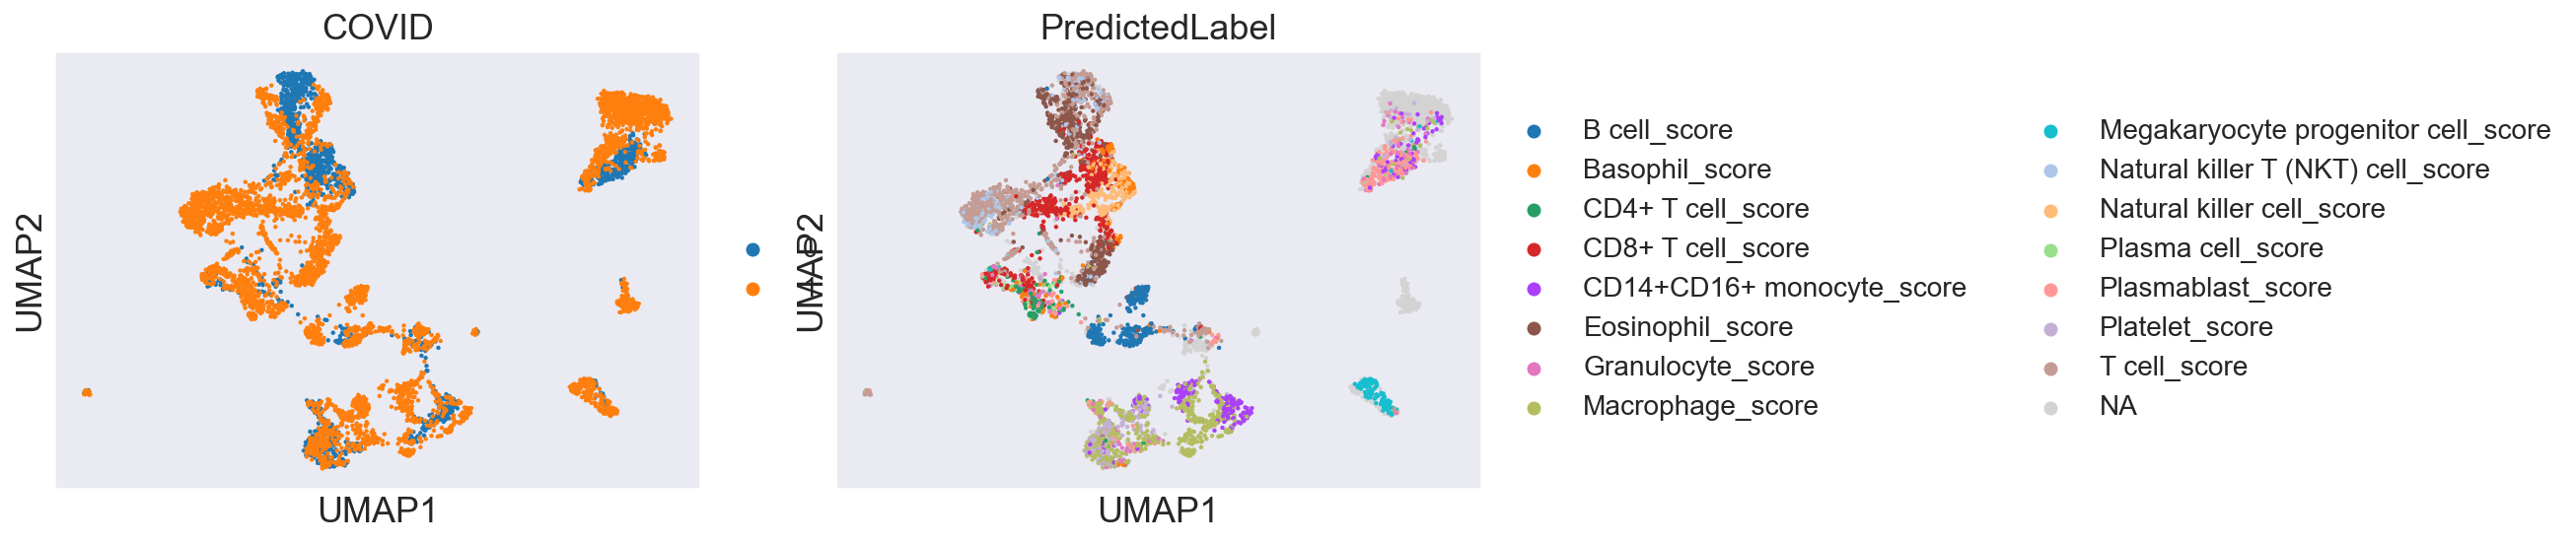

In [462]:
adata.obs.COVID = adata.obs.COVID.astype('category')
sc.pl.umap(adata, color=['COVID', 'PredictedLabel'], wspace=.1)

In [507]:
tidyH = pd.DataFrame(nmf.transform(adata[:, not_excluded].X),
                     index=adata.obs.index,
                     columns=['NMF' + str(i + 1) for i in range(nmf.components_.shape[0])])\
           .reset_index()\
           .rename(columns={'index': 'cell'})\
           .melt(id_vars='cell', var_name='NMF', value_name='Value')
tidyH = tidyH.join(adata.obs, on='cell')

for name, df in tidyH.groupby(['NMF', 'PredictedLabel']):
    ratio = np.median(df[df.COVID == 1].Value  + 10 ** -6) / np.median(df[df.COVID == 0].Value + 10 ** -6)
    if 0.5 < ratio < 2:
        continue
    print(name)
    print(df.groupby('COVID').COVID.count())
    print('median no COVID', np.median(df[df.COVID == 0].Value))
    print(ratio)
#     print(df.Value.min(), df.Value.mean(), df.Value.max())

('NMF1', 'CD4+ T cell_score')
COVID
0     17
1    103
Name: COVID, dtype: int64
median no COVID 0.26333782
2.2019763
('NMF1', 'Granulocyte_score')
COVID
0    53
1    68
Name: COVID, dtype: int64
median no COVID 0.0
60181.7
('NMF2', 'CD4+ T cell_score')
COVID
0     17
1    103
Name: COVID, dtype: int64
median no COVID 0.06199818
1.6129246e-05
('NMF2', 'Granulocyte_score')
COVID
0    53
1    68
Name: COVID, dtype: int64
median no COVID 0.80079675
0.08691712
('NMF2', 'Plasmablast_score')
COVID
0    122
1    115
Name: COVID, dtype: int64
median no COVID 0.87550616
0.49412796
('NMF2', 'T cell_score')
COVID
0    185
1    649
Name: COVID, dtype: int64
median no COVID 0.0028302625
4.6890993
('NMF3', 'Basophil_score')
COVID
0    66
1    80
Name: COVID, dtype: int64
median no COVID 0.0
2354.5151
('NMF3', 'Natural killer cell_score')
COVID
0    102
1    149
Name: COVID, dtype: int64
median no COVID 0.0
28084.445
('NMF3', 'Platelet_score')
COVID
0     94
1    143
Name: COVID, dtype: int64
median n

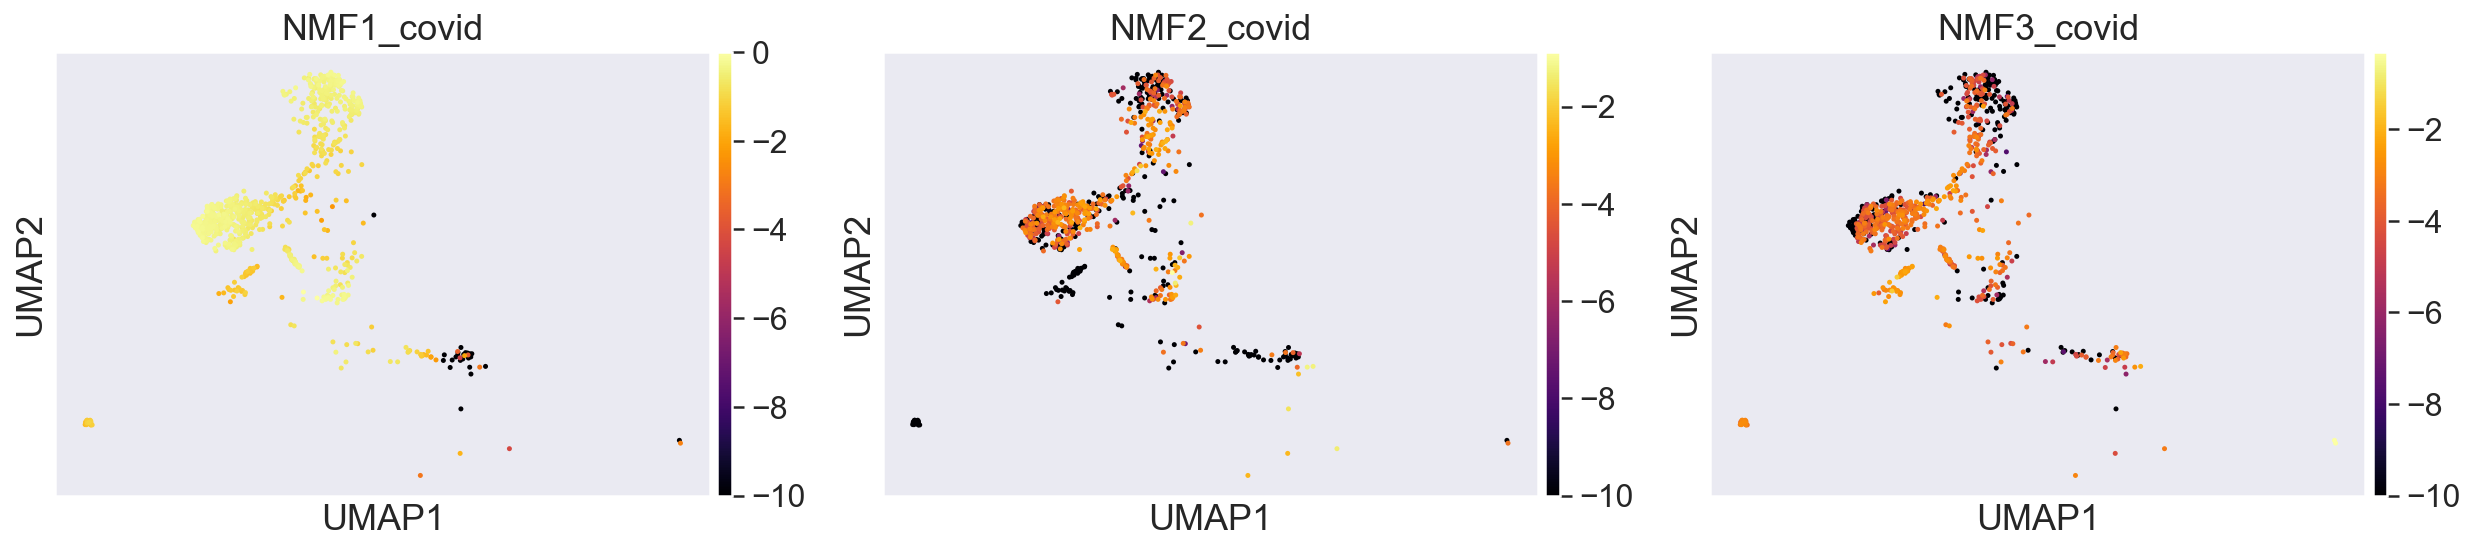

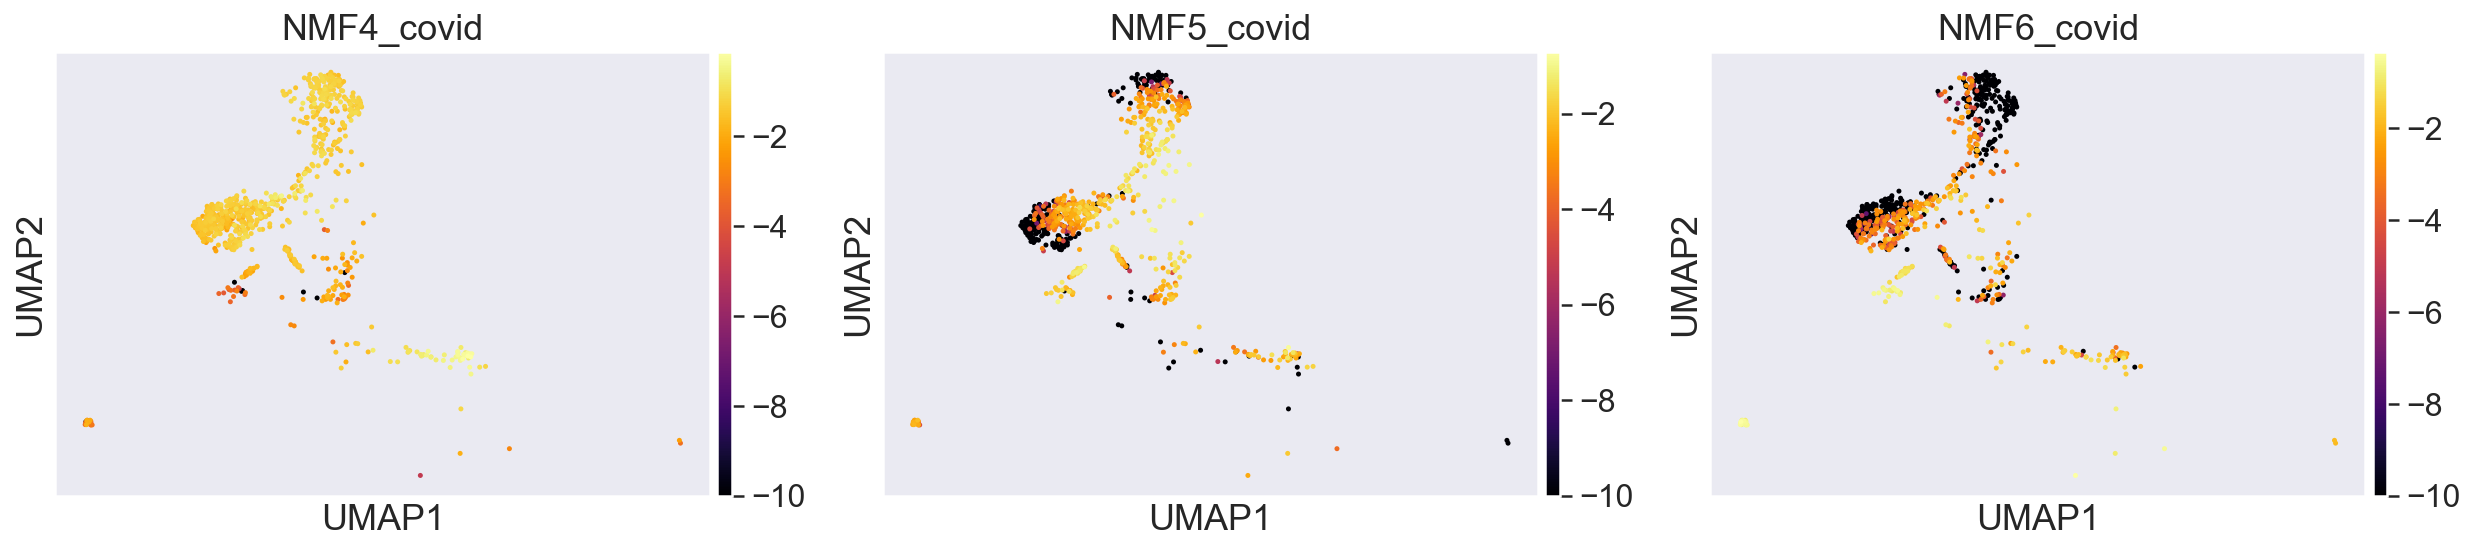

In [511]:
fit_model_and_plot(adata[adata.obs.PredictedLabel == 'T cell_score', not_excluded], suffix='_covid', plot=plot, nmf=nmf,
                   vmin=-10, s=25)

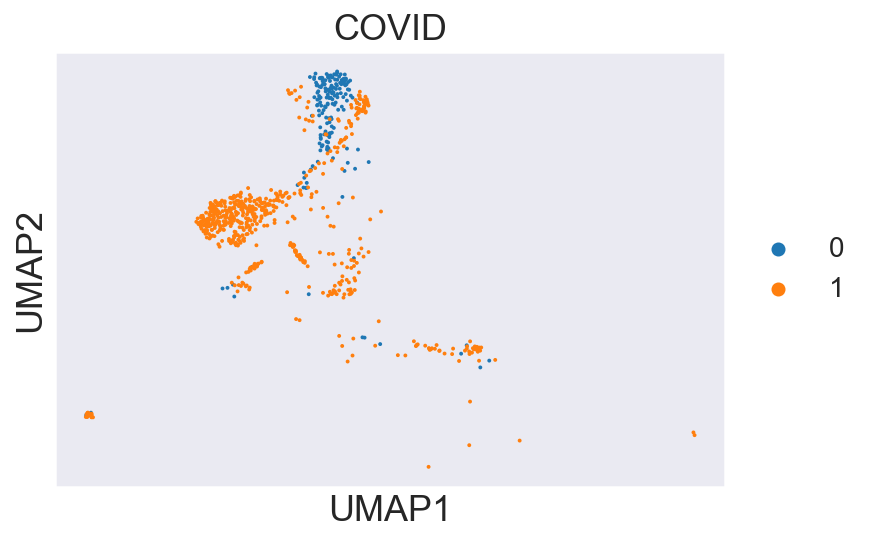

In [513]:
sc.pl.umap(adata[adata.obs.PredictedLabel == 'T cell_score', not_excluded], color=['COVID'], wspace=.1, s=15)

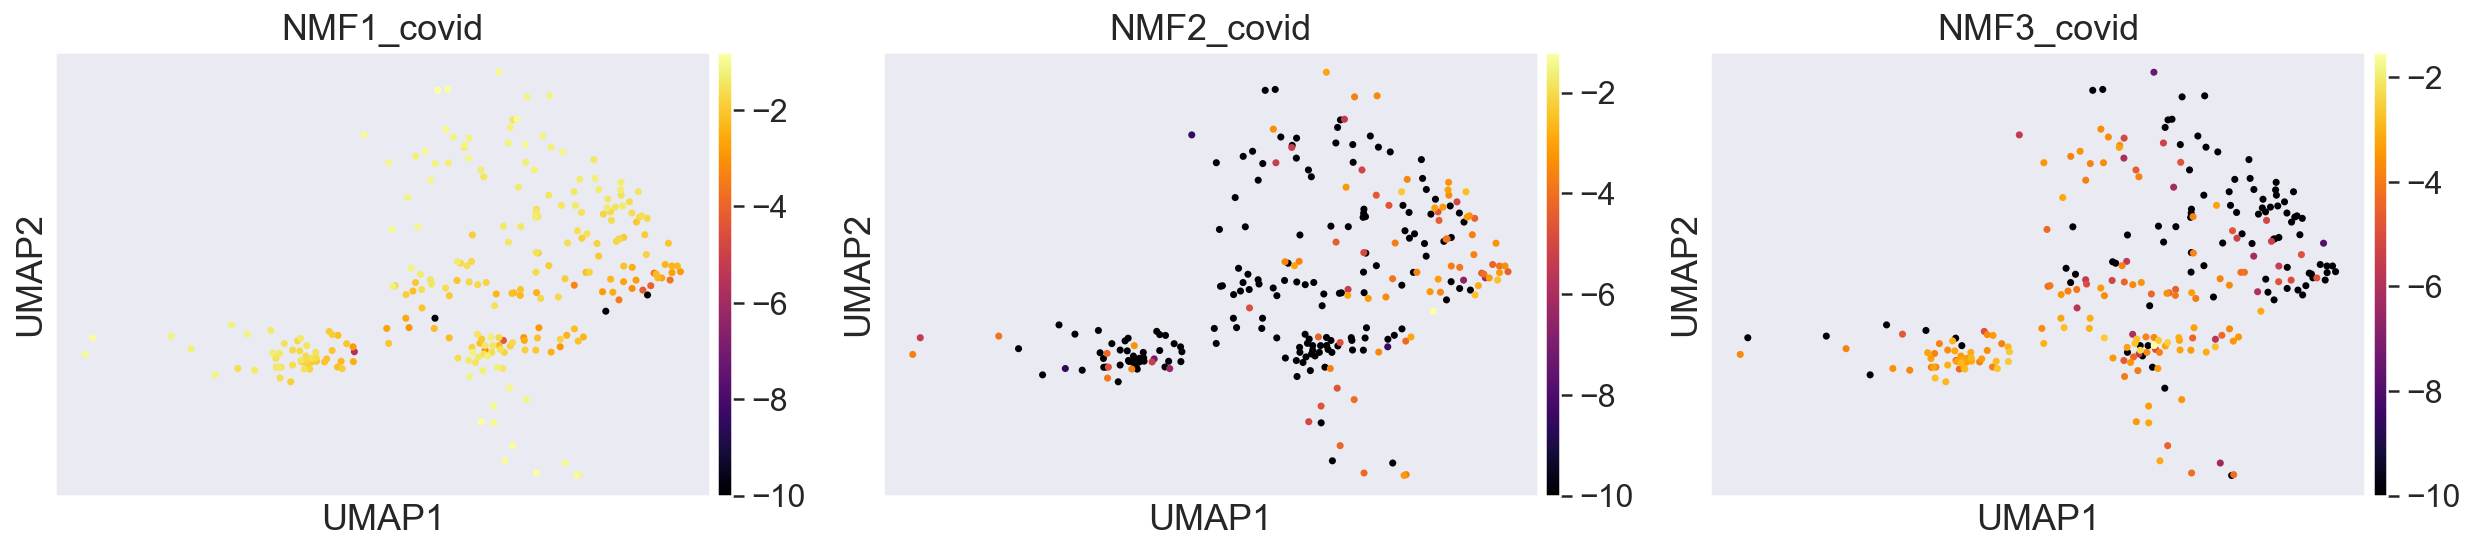

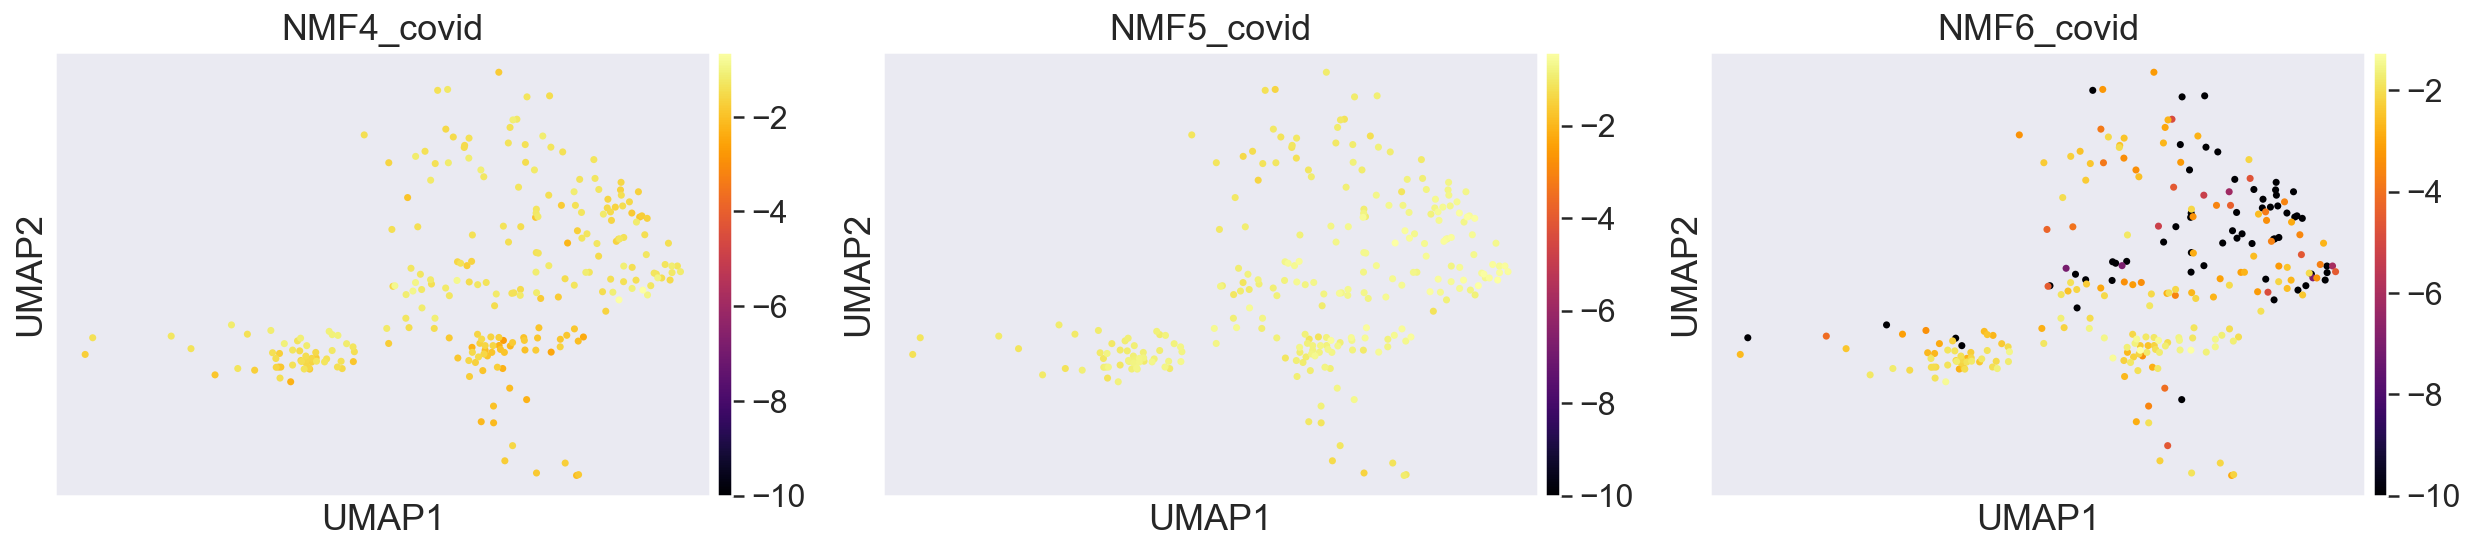

In [514]:
fit_model_and_plot(adata[adata.obs.PredictedLabel == 'Natural killer cell_score', not_excluded], suffix='_covid', plot=plot, nmf=nmf,
                   vmin=-10, s=50)

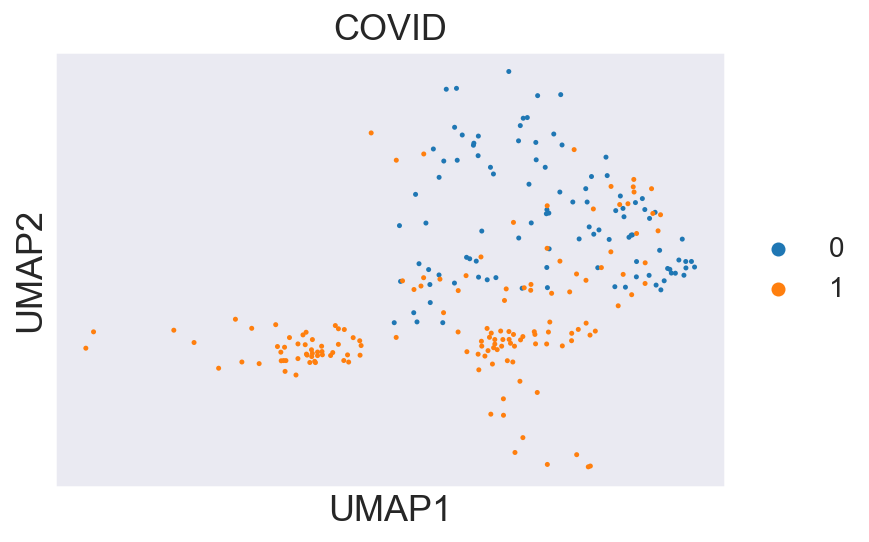

In [515]:
sc.pl.umap(adata[adata.obs.PredictedLabel == 'Natural killer cell_score', not_excluded], color=['COVID'], wspace=.1, s=25)